In [45]:
import pandas as pd
import numpy as np
import urllib.request
import boto3

import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
sess = sagemaker.Session()
bucket='analytics-serverless-west'
prefix = 'sagemaker/x-ray'

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

def download_from_s3(bucket, key, local_file_name):
    s3 = boto3.resource('s3')
    s3.Bucket(bucket).download_file(key, local_file_name)

trainper = 0.7
valper = 0.1
file_name = 'Data_Entry_2017.csv'

download_from_s3(bucket, prefix+'/'+file_name, file_name)

a = pd.read_csv(file_name)
patient_ids = a['Patient ID']
uniq_pids = np.unique(patient_ids)
np.random.shuffle(uniq_pids)
total_ids = len(uniq_pids)
a.to_csv('dataentry.csv', sep=',', header=False, index=False)

In [ ]:
!aws s3 cp "s3://analytics-serverless-west/sagemaker/x-ray/thresholdoutput"  . --recursive

In [46]:
import csv

def gen_set(csvfile):
    alldict = dict()
    alldicti = dict()
    disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', \
                   'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', \
                   'Hernia']
    alldiseases = {disease:i for i,disease in enumerate(disease_list)}
    with open(csvfile, 'r') as cfile:
        line = csv.reader(cfile, delimiter=',')
        index = 0
        for element in line:
            dd = []
             # the first column is the image filename, while the second
            # column has the list of diseases separated by |
            diseases = element[1].split('|')
            for d in alldiseases:
                if d in diseases:
                    dd.append(1)
                else:
                    dd.append(0)
            alldict[element[0]] = dd
            alldicti[element[0]] = index
            index += 1
    return alldict, alldicti
                
file_name = 'dataentry.csv'
dicts, dictsi = gen_set(file_name)

In [47]:
print(dicts['00000001_000.png'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [48]:
import json
import glob

prediction = dict()
list_of_files = glob.glob('*.out')
predictions = np.zeros((len(list_of_files), 14), dtype='float')
gts = np.zeros((len(list_of_files), 14), dtype='float')
for filename in list_of_files:
    with open(filename, 'r') as f:
        p = json.load(f)
    f = filename[:-4]
    prediction[f] = p['prediction']
    index = dictsi[f]
    predictions[index, :] = p['prediction']
    gts[index, :] = dicts[f]
    #print(index)
    #break

[0.77809501 0.73961931 0.67294449 0.46159554 0.43322346 0.42636141
 0.36443788 0.34368435 0.3221482  0.31790704 0.31354347 0.31015769
 0.30217472 0.29703569 0.29214287 0.28683349 0.26913807 0.26574951
 0.26397038 0.26317683 0.22602572 0.21995918 0.21084835 0.21076697
 0.18381791 0.18332019 0.17162751 0.16906278 0.16855527 0.1673553
 0.16169082 0.16144142 0.15831161 0.15799987 0.14485529 0.14383966
 0.14238918 0.14074978 0.08858769 0.08509537 0.00904806]
Atelectasis 0.778095006942749
Atelectasis 0.17162750661373138


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


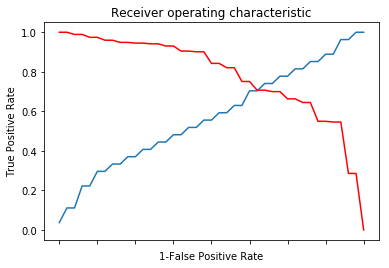

[1.29209897 0.29209897 0.21849994 0.21682915 0.21031496 0.20665474
 0.18505377 0.18256012 0.17626722 0.17624232 0.16240078 0.16224886
 0.14273721 0.14269955 0.14164864 0.13634157 0.08100787 0.07994683
 0.03749126 0.03651172 0.00335582]
Consolidation 1.2920989692211151
Consolidation 0.13634157180786133


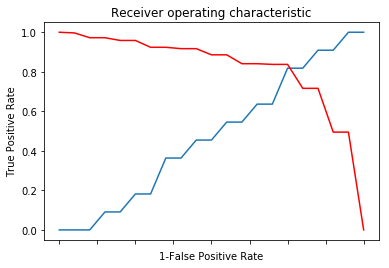

[1.46057424 0.46057424 0.43340519 0.43130162 0.40912375 0.38954672
 0.38688716 0.38269266 0.37978873 0.37944192 0.37715501 0.37041828
 0.37021968 0.36398229 0.36270043 0.35155407 0.34877002 0.34872264
 0.34790567 0.34543377 0.34514895 0.33570552 0.33431229 0.3327758
 0.33073211 0.32383063 0.32278532 0.31827563 0.31503943 0.31480223
 0.31434593 0.31230608 0.31159639 0.31145909 0.30917501 0.30658224
 0.30574226 0.30059561 0.29587951 0.2935451  0.29229036 0.2851049
 0.28202137 0.27766094 0.27725956 0.27454919 0.26698789 0.26257023
 0.26192844 0.25687903 0.25437894 0.25291207 0.25279388 0.25265309
 0.25226894 0.25110483 0.24986352 0.24012798 0.23901412 0.23822096
 0.23371348 0.22206938 0.22114122 0.21164368 0.20996006 0.20531154
 0.20335373 0.19280249 0.19269268 0.18812792 0.1854009  0.18294552
 0.18293749 0.17992905 0.17990991 0.1791188  0.17870815 0.17657374
 0.17610608 0.17456733 0.17451766 0.17315884 0.17019865 0.16963412
 0.16837561 0.16443132 0.16409005 0.1631279  0.16205539 0.161410

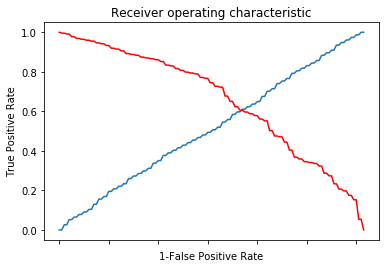

[0.62571162 0.55086452 0.43007952 0.41877681 0.36064127 0.34202605
 0.33632222 0.32895035 0.29903755 0.29232398 0.28028762 0.24769707
 0.21222071 0.19702825 0.18912219 0.09026214 0.08858224 0.08071745
 0.07983416 0.07902881 0.07594524 0.04203616 0.04178761 0.00509779]
Pneumothorax 0.6257116198539734
Pneumothorax 0.08858224004507065


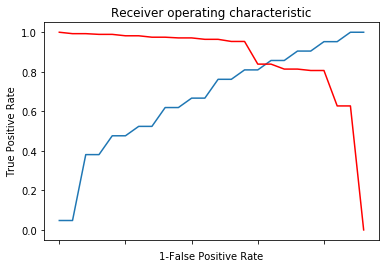

[2.71362275e-01 2.19439596e-01 1.99187011e-01 1.94700375e-01
 1.92264423e-01 1.60073504e-01 1.49006501e-01 1.47201166e-01
 1.37131780e-01 1.33004904e-01 1.29364893e-01 1.29089624e-01
 1.26669139e-01 1.16304159e-01 1.15443215e-01 1.07842550e-01
 1.07756741e-01 1.07534386e-01 1.06674418e-01 1.02998033e-01
 1.02680378e-01 9.98219997e-02 9.90822613e-02 8.61764401e-02
 8.38918313e-02 8.29738453e-02 7.80922398e-02 7.77304545e-02
 7.70285577e-02 6.69303909e-02 6.68288991e-02 6.41497001e-02
 6.29178435e-02 5.93312234e-02 5.82541786e-02 2.78580505e-02
 2.68945917e-02 1.51059940e-04]
Edema 0.2713622748851776
Edema 0.066930390894413


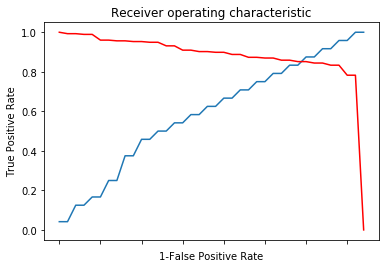

[0.78428918 0.76217628 0.73283362 0.65882289 0.60700941 0.4691231
 0.33230615 0.19371079 0.11421915 0.09990791 0.08857041 0.08536272
 0.05347598 0.04855211 0.04475462 0.04390145 0.0423548  0.04149502
 0.03993072 0.03908752 0.03022913 0.03020127 0.02073579 0.02026919
 0.01348039 0.01346636 0.01027344 0.01016279 0.00110059]
Emphysema 0.7842891812324524
Emphysema 0.03022913448512554


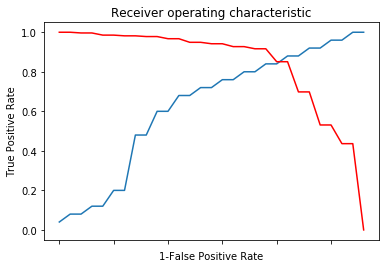

[0.39154181 0.22749621 0.20705725 0.12629439 0.11740673 0.05787474
 0.05605021 0.04749443 0.04746385 0.03786326 0.03742578 0.0298179
 0.029558   0.01470712 0.01450526 0.01048284 0.01028861 0.00115148]
Fibrosis 0.39154180884361267
Fibrosis 0.02981789968907833


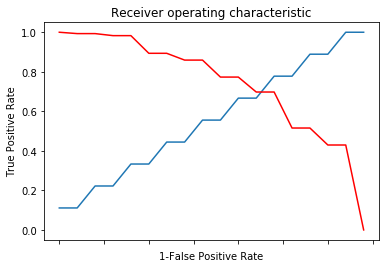

[0.64971852 0.62324727 0.55197287 0.52589822 0.51275533 0.49563509
 0.48896173 0.48080635 0.4533774  0.44633105 0.44243824 0.43455231
 0.42106479 0.39780104 0.39490825 0.38006634 0.37559414 0.36787251
 0.36700645 0.36632851 0.36330897 0.35917318 0.35290334 0.34265694
 0.34084931 0.34078288 0.34050718 0.32433799 0.32237968 0.31881925
 0.31330672 0.30461785 0.30358395 0.30072847 0.30043334 0.29614976
 0.28895113 0.28761351 0.28532848 0.28174844 0.27742609 0.25081491
 0.24754971 0.2417011  0.24159001 0.2410908  0.24083951 0.22701594
 0.22261871 0.22141677 0.21716802 0.20747641 0.20736948 0.19669642
 0.19432783 0.18489896 0.18233426 0.16855803 0.16787076 0.13968696
 0.13941075 0.13794094 0.13732557 0.12827317 0.12822941 0.11480623
 0.11334912 0.10771766 0.10694539 0.08926553 0.08703433 0.00318109]
Effusion 0.6497185230255127
Effusion 0.24083951115608215


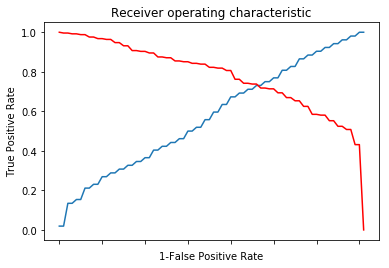

[1.05560260e+00 5.56025952e-02 4.36374173e-02 4.20119837e-02
 2.93716062e-02 2.87778750e-02 2.72340421e-02 2.71583702e-02
 1.22334370e-02 1.21978447e-02 9.28115752e-03 9.25649609e-03
 9.11458337e-04]
Pneumonia 1.0556025952100754
Pneumonia 0.012233437038958073


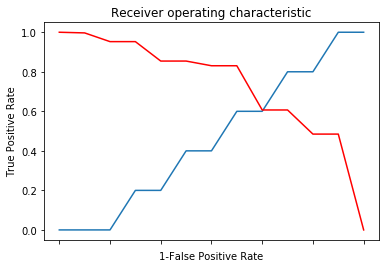

[1.39030227 0.39030227 0.22965598 0.21771863 0.15109608 0.14979422
 0.13886844 0.12962379 0.12488078 0.12422857 0.12185456 0.11974277
 0.11927076 0.11839498 0.1131199  0.11299739 0.10261443 0.10074372
 0.08263493 0.08142122 0.06534482 0.06420181 0.03920005 0.03917702
 0.00241358]
Pleural_Thickening 1.3903022706508636
Pleural_Thickening 0.08263493329286575


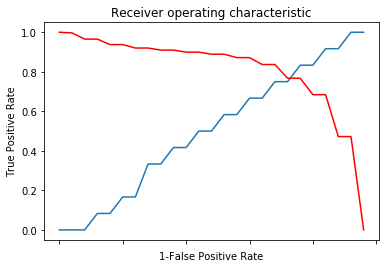

[7.53848016e-01 6.73366606e-01 6.34702206e-01 5.92393875e-01
 5.91424584e-01 5.89807689e-01 5.54242134e-01 5.52766621e-01
 5.43437421e-01 5.43375075e-01 5.33755779e-01 5.02353728e-01
 4.47972417e-01 4.23272610e-01 3.81288201e-01 3.75790387e-01
 3.64728183e-01 3.49065900e-01 3.05659801e-01 2.98372328e-01
 2.75358766e-01 2.74195433e-01 2.62428969e-01 2.55160183e-01
 2.51367182e-01 2.22459272e-01 2.07655117e-01 2.01560900e-01
 1.98193401e-01 1.88251227e-01 1.87215269e-01 1.86081976e-01
 1.69163451e-01 1.61624402e-01 1.46782279e-01 1.36412442e-01
 1.35624334e-01 1.34654254e-01 1.23369604e-01 1.22045673e-01
 1.13349691e-01 1.12106517e-01 1.01803467e-01 1.00308575e-01
 8.36732760e-02 8.30576271e-02 5.45195490e-02 5.33365123e-02
 4.97445539e-02 4.79126982e-02 2.74759426e-04]
Cardiomegaly 0.7538480162620544
Cardiomegaly 0.13562433421611786


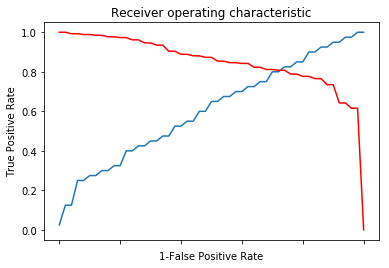

[1.36435583 0.36435583 0.11115386 0.11089097 0.105892   0.10454281
 0.10294917 0.09973773 0.07809231 0.0772509  0.06214993 0.06192493
 0.05311314 0.05298026 0.0507721  0.05036072 0.04809793 0.04745719
 0.03532175 0.03507941 0.03307131 0.03294844 0.03143039 0.0314032
 0.02381724 0.02365522 0.00874634]
Nodule 1.3643558323383331
Nodule 0.047457192093133926


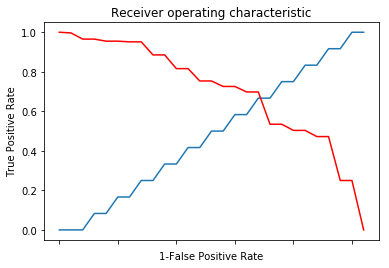

[1.25917691 0.25917691 0.25583768 0.1529616  0.13938746 0.06110429
 0.05944188 0.0521066  0.0517757  0.05022703 0.04964756 0.04529881
 0.04483605 0.04454263 0.04451679 0.04096346 0.04061468 0.03927405
 0.03906236 0.03868226 0.03865235 0.0370083  0.03683739 0.03427591
 0.03424316 0.03347943 0.03341186 0.03022334 0.02992975 0.02655951
 0.0264227  0.02499952 0.0249216  0.01779091 0.01767389 0.0159366
 0.01569219 0.00388898]
Mass 1.2591769099235535
Mass 0.034243155270814896


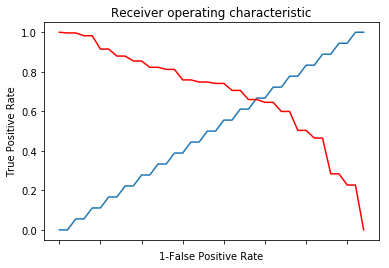

[0.05428028 0.03867748 0.02957146 0.02681801 0.0248108  0.02462447
 0.02427591 0.02403288 0.01199858 0.01194128 0.00011211]
Hernia 0.05428028479218483
Hernia 0.011998575180768967


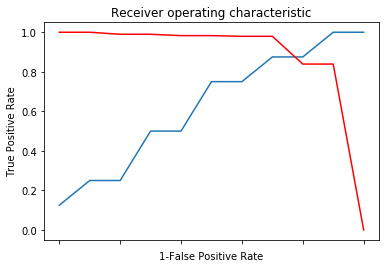

In [54]:
from sklearn import metrics
disease_list = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', \
                   'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', \
                   'Hernia']
for j in range(0, 14):
    aa = predictions[:, j]
    bb = gts[:, j]
    fpr, tpr, thresholds = metrics.roc_curve(bb, aa)
    print(thresholds)

    for idx, i in enumerate(fpr):
        if(i < 0.8):
            print(disease_list[j], thresholds[idx])
            break
            
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    tdf = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    print(disease_list[j], tdf['thresholds'].item())

    import pylab as pl

    fig, ax = pl.subplots()
    pl.plot(roc['tpr'])
    pl.plot(roc['1-fpr'], color = 'red')
    pl.xlabel('1-False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title('Receiver operating characteristic')
    ax.set_xticklabels([])
    pl.show()

In [39]:
print(thresholds)
print(tpr)
print(fpr)

[0.05428028 0.03867748 0.02957146 0.02681801 0.0248108  0.02462447
 0.02427591 0.02403288 0.01199858 0.01194128 0.00011211]
[0.125 0.25  0.25  0.5   0.5   0.75  0.75  0.875 0.875 1.    1.   ]
[0.         0.         0.01027397 0.01027397 0.01712329 0.01712329
 0.02054795 0.02054795 0.1609589  0.1609589  1.        ]
